In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

2024-09-30 14:03:45.759943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 14:03:46.012954: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 14:03:46.120826: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 14:03:47.014924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

In [2]:
def calculate_RSI(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [3]:
# Download Stock Data
stock_symbol = 'SPY'
data = yf.download(stock_symbol, start='2020-01-01', end='2024-08-05')
vix = yf.download('^VIX', start='2020-01-01', end='2024-08-05')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Get acutal data
a_data = yf.download(stock_symbol, start='2024-08-06', end='2024-08-31')
a_data.dropna(inplace=True)
a_data = a_data['Close']
a_data = pd.DataFrame(a_data)[:10]

[*********************100%***********************]  1 of 1 completed


In [5]:
# Prepare Data
short_window = 12
long_window = 26
signal_window = 9
data['RSI'] = calculate_RSI(data, 9)
data['EMA12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=long_window, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
data['VIX'] = vix['Close']
data

,Open,High,Low,Close,Adj Close,Volume,RSI,EMA12,EMA26,MACD,Signal_Line,VIX
Date,,,,,,,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,302.208588,59151200,NaN,324.869995,324.869995,0.000000,0.000000,12.470000
2020-01-03,321.160004,323.640015,321.100006,322.410004,299.920227,77709700,NaN,324.491535,324.687774,-0.196239,-0.039248,14.020000
2020-01-06,320.489990,323.730011,320.359985,323.640015,301.064453,55653900,NaN,324.360532,324.610162,-0.249630,-0.081324,13.850000
2020-01-07,323.019989,323.540009,322.239990,322.730011,300.217957,40496400,NaN,324.109682,324.470891,-0.361209,-0.137301,13.790000
2020-01-08,322.940002,325.779999,322.670013,324.450012,301.817932,68296000,NaN,324.162041,324.469345,-0.307304,-0.171302,13.450000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29,546.020020,547.049988,542.719971,544.760010,543.094177,39515800,27.221303,548.691561,548.194503,0.497057,3.006251,16.600000
2024-07-30,546.260010,547.340027,538.520020,542.000000,540.342590,46853600,30.826556,547.662090,547.735651,-0.073561,2.390288,17.690001
2024-07-31,548.979980,553.500000,547.580017,550.809998,549.125671,65663400,47.873108,548.146383,547.963380,0.183003,1.948831,16.360001


In [6]:
# Select relevant features: Closing price, Volume, MACD, RSI, VIX
data = data[['Close', 'Volume', 'MACD', 'RSI', 'VIX']]

# Drop any NaN values that might exist
data.dropna(inplace=True)

# Prepare the dataset for multiple days ahead prediction
n_future_days = 10  # Predict the next 5 trading days
n_past_days = 60   # Use past 300 days to predict future

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

scaled_data

/tmp/ipykernel_54/3049434880.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


array([[0.30563604, 0.09944942, 0.73217775, 0.59095935, 0.00748271],
       [0.30780032, 0.12466741, 0.73753288, 0.61435085, 0.00790626],
       [0.31578491, 0.07543796, 0.74807769, 0.81543586, 0.00649442],
       ...,
       [0.95890735, 0.10718832, 0.72481626, 0.45919125, 0.06353241],
       [0.93609436, 0.13662078, 0.71207166, 0.41611542, 0.09501624],
       [0.90652522, 0.15401019, 0.67788702, 0.26457536, 0.16278412]])

In [7]:
# Create the dataset with multiple future days
X_train = []
y_train = []
for i in range(n_past_days, len(scaled_data) - n_future_days):
    X_train.append(scaled_data[i - n_past_days:i])
    y_train.append(scaled_data[i:i + n_future_days, 0])  # Predict 'Close' for future days

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(n_future_days))  # Output layer adjusted for future days

model.compile(optimizer='SGD', loss='mean_squared_error')

# Train the model
obj = model.fit(X_train, y_train, epochs=50, batch_size=8)
obj

Epoch 1/50
135/135 [==============================] - 3s 13ms/step - loss: 0.1170
Epoch 2/50
135/135 [==============================] - 2s 13ms/step - loss: 0.0319
Epoch 3/50
135/135 [==============================] - 2s 12ms/step - loss: 0.0251
Epoch 4/50
135/135 [==============================] - 2s 13ms/step - loss: 0.0233
Epoch 5/50
135/135 [==============================] - 2s 13ms/step - loss: 0.0218
Epoch 6/50
135/135 [==============================] - 2s 13ms/step - loss: 0.0201
Epoch 7/50
135/135 [==============================] - 2s 13ms/step - loss: 0.0180
Epoch 8/50
135/135 [==============================] - 2s 12ms/step - loss: 0.0156
Epoch 9/50
135/135 [==============================] - 2s 13ms/step - loss: 0.0127
Epoch 10/50
135/135 [==============================] - 2s 13ms/step - loss: 0.0098
Epoch 11/50
135/135 [==============================] - 2s 12ms/step - loss: 0.0073
Epoch 12/50
135/135 [==============================] - 2s 13ms/step - loss: 0.0057
Epoch 13/50
1

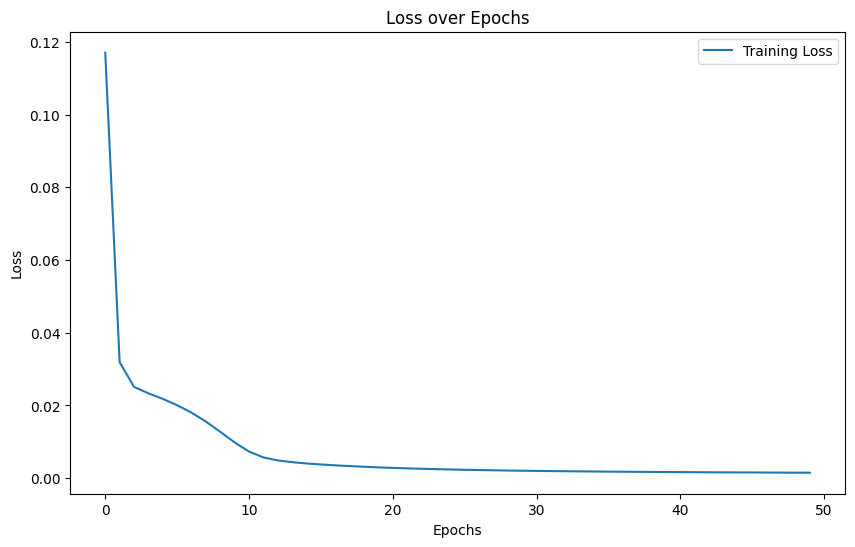

In [14]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(obj.history['loss'], label='Training Loss')

# If validation data was used, plot validation loss as well
if 'val_loss' in obj.history:
    plt.plot(obj.history['val_loss'], label='Validation Loss')

# Customize the plot
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Predict the next few trading days
predictions = model.predict(X_train[-1].reshape(1, n_past_days, X_train.shape[2]))

# Flatten predictions and reshape to match the dimensions
predictions = predictions.flatten().reshape(-1, 1)

# Create an array of zeros for other features to inverse transform
dummy_array = np.zeros((n_future_days, scaled_data.shape[1] - 1))



1/1 [==============================] - 0s 328ms/step


In [16]:
# Concatenate and inverse transform
predicted_prices = scaler.inverse_transform(np.hstack((predictions, dummy_array)))[:,0]  # Only take 'Close' values
# len(predicted_prices)
# len(a_data)

# Assign predicted_prices to a_data['Pred']

a_data['Pred'] = predicted_prices
a_data['difference (%)'] = ((a_data['Pred'] - a_data['Close']) / a_data['Close']) * 100
# Print the DataFrame to check the assignment

a_data


,Close,Pred,difference (%)
Date,,,
2024-08-06,522.150024,543.811607,4.148536
2024-08-07,518.659973,532.887951,2.743219
2024-08-08,530.650024,536.567762,1.115186
2024-08-09,532.989990,531.547454,-0.270650
2024-08-12,533.270020,546.841518,2.544958
2024-08-13,542.039978,540.887262,-0.212663
2024-08-14,543.750000,541.864720,-0.346718
2024-08-15,553.070007,536.755762,-2.949761
2024-08-16,554.309998,540.012964,-2.579249


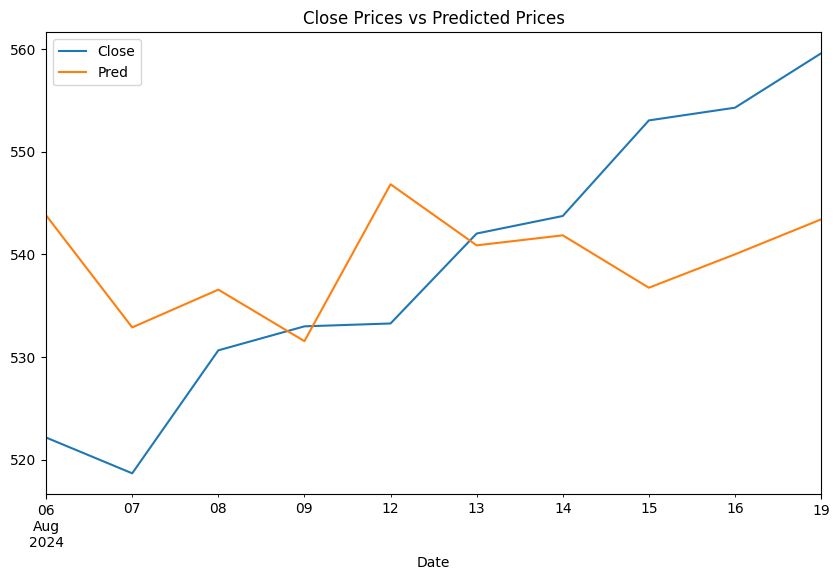

In [17]:
a_data.plot(y=['Close', 'Pred'], figsize=(10, 6), title='Close Prices vs Predicted Prices')
plt.show()